# Projet Speed Dating - Analyse et Modélisation
Ce notebook contient l'analyse exploratoire des données de speed dating ainsi qu'un modèle prédictif pour estimer la probabilité d'obtenir un match en fonction des critères perçus.

In [17]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Charger le dataset
dataset_path = "Speed+Dating+Data.csv"  # Adapter le chemin si nécessaire
df = pd.read_csv(dataset_path, encoding="latin1")

# Aperçu des premières lignes
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 195 entries, iid to amb5_3
dtypes: float64(174), int64(13), object(8)
memory usage: 12.5+ MB


,iid,id,gender,idg,condtn,wave,round,position,positin1,order,...,attr3_3,sinc3_3,intel3_3,fun3_3,amb3_3,attr5_3,sinc5_3,intel5_3,fun5_3,amb5_3
0,1,1.0,0,1,1,1,10,7,NaN,4,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
1,1,1.0,0,1,1,1,10,7,NaN,3,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
2,1,1.0,0,1,1,1,10,7,NaN,10,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
3,1,1.0,0,1,1,1,10,7,NaN,5,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN
4,1,1.0,0,1,1,1,10,7,NaN,7,...,5.0,7.0,7.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN


In [18]:
# Analyse des valeurs manquantes
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

# Affichage des variables avec le plus de valeurs manquantes
missing_values.head(20)

num_in_3    7710
numdat_3    6882
expnum      6578
sinc7_2     6423
amb7_2      6423
shar7_2     6404
attr7_2     6394
intel7_2    6394
fun7_2      6394
amb5_3      6362
sinc7_3     6362
intel7_3    6362
fun7_3      6362
amb7_3      6362
shar7_3     6362
attr7_3     6362
fun5_3      6362
intel5_3    6362
sinc5_3     6362
attr5_3     6362
dtype: int64

In [19]:
# Suppression des colonnes avec plus de 50% de valeurs manquantes
threshold = len(df) * 0.5
df_cleaned = df.dropna(thresh=threshold, axis=1).copy()

# Remplissage des valeurs manquantes restantes par la médiane (si numérique)
for col in df_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    df_cleaned.loc[:, col] = df_cleaned[col].fillna(df_cleaned[col].median())

# Vérification après nettoyage
df_cleaned.isnull().sum().sum()  # Nombre total de valeurs manquantes après traitement


8858

/opt/anaconda3/envs/mon_env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


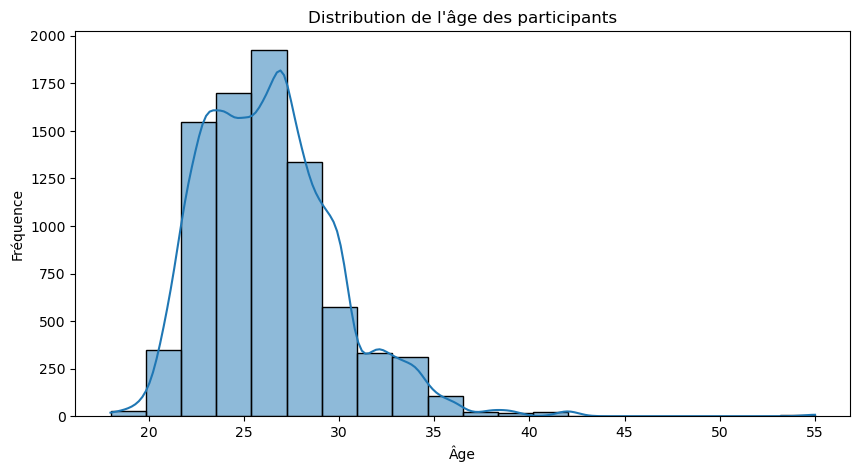

In [20]:
# Visualisation de la distribution de l'âge des participants
plt.figure(figsize=(10, 5))
sns.histplot(df['age'].dropna(), bins=20, kde=True)
plt.title("Distribution de l'âge des participants")
plt.xlabel("Âge")
plt.ylabel("Fréquence")
plt.show()

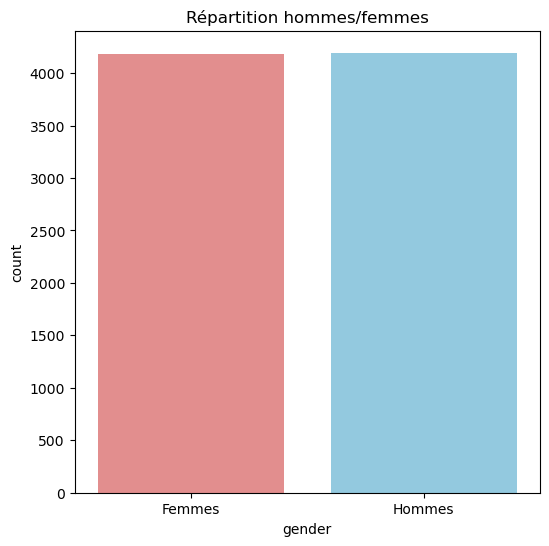

In [21]:
# Répartition hommes/femmes
plt.figure(figsize=(6, 6))
sns.countplot(x=df['gender'], palette=["lightcoral", "skyblue"])
plt.xticks([0, 1], ["Femmes", "Hommes"])
plt.title("Répartition hommes/femmes")
plt.show()

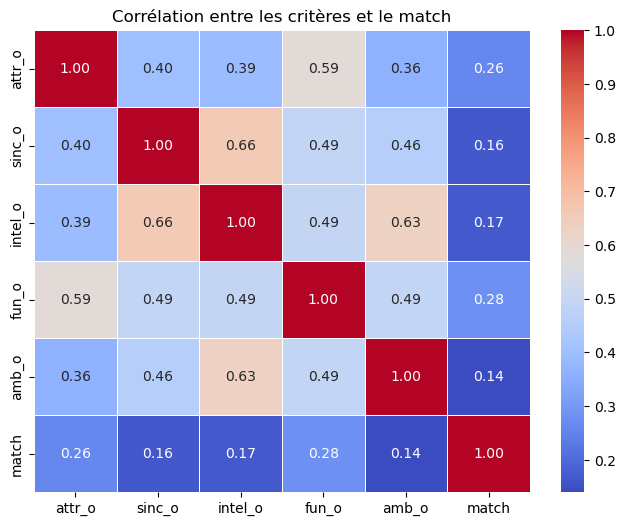

In [22]:
# Influence des critères sur le match (corrélations)
criteria = ['attr_o', 'sinc_o', 'intel_o', 'fun_o', 'amb_o']
df_corr = df[criteria + ['match']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Corrélation entre les critères et le match")
plt.show()

In [23]:
# Tester la corrélation entre l'âge et le fait d'obtenir un match
df_filtered = df[["age", "match"]].dropna()
age_match_corr, age_match_pval = stats.pearsonr(df_filtered["age"], df_filtered["match"])

print("Corrélation âge-match:", age_match_corr)
print("p-valeur:", age_match_pval)

Corrélation âge-match: -0.035055140403132734
p-valeur: 0.0014182931569076277


In [24]:
# Test du Chi² entre le genre et le match
contingency_table = pd.crosstab(df["gender"], df["match"])
chi2_stat, chi2_pval, _, _ = stats.chi2_contingency(contingency_table)

print("Test du Chi² genre-match: Statistique =", chi2_stat)
print("p-valeur =", chi2_pval)

Test du Chi² genre-match: Statistique = 0.0003633509204105355
p-valeur = 0.9847918322511705


In [25]:
# Sélection des variables explicatives et préparation des données
features = ["age", "attr_o", "sinc_o", "intel_o", "fun_o", "amb_o"]
df_model = df[features + ["match"]].dropna()

# Normalisation des features
scaler = StandardScaler()
X = scaler.fit_transform(df_model[features])
y = df_model["match"]

# Séparation en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Entraînement du modèle de régression logistique
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Précision du modèle
train_score = log_reg.score(X_train, y_train)
test_score = log_reg.score(X_test, y_test)

print("Score entraînement:", train_score)
print("Score test:", test_score)

Score entraînement: 0.8263122701437646
Score test: 0.8262032085561497


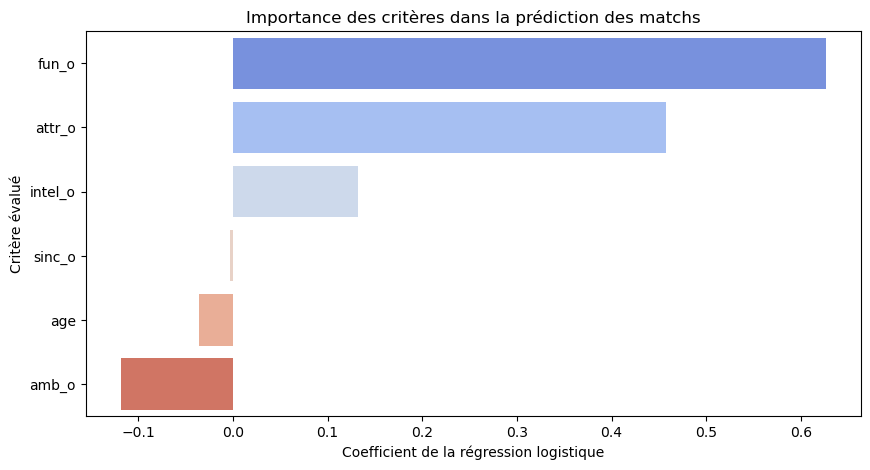

In [27]:
# Importance des critères dans la prédiction des matchs
coef_df = pd.DataFrame({
    "Critère": features,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Coefficient", y="Critère", data=coef_df, palette="coolwarm")
plt.title("Importance des critères dans la prédiction des matchs")
plt.xlabel("Coefficient de la régression logistique")
plt.ylabel("Critère évalué")
plt.show()

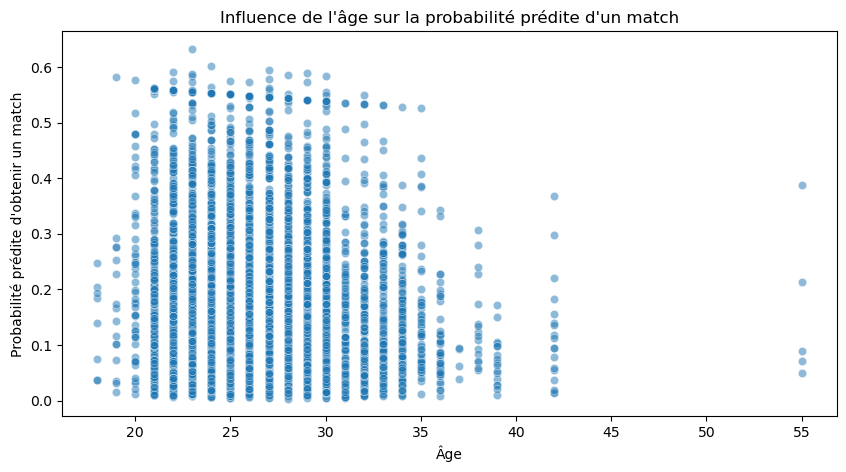

In [28]:
# Visualisation de la relation entre l'âge et la probabilité de match prédite
df_model["probabilité_match"] = log_reg.predict_proba(X)[:, 1]

plt.figure(figsize=(10, 5))
sns.scatterplot(x=df_model["age"], y=df_model["probabilité_match"], alpha=0.5)
plt.xlabel("Âge")
plt.ylabel("Probabilité prédite d'obtenir un match")
plt.title("Influence de l'âge sur la probabilité prédite d'un match")
plt.show()

<Figure size 600x600 with 0 Axes>

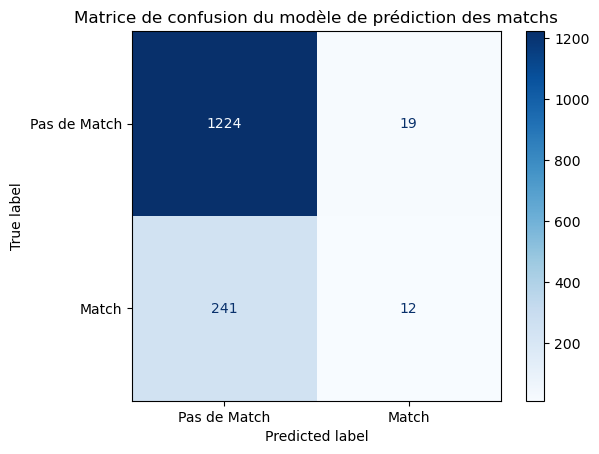

In [29]:
# Matrice de confusion pour voir la performance du modèle
y_pred = log_reg.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pas de Match", "Match"])

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Matrice de confusion du modèle de prédiction des matchs")
plt.show()